In [1]:
from sklearn.cluster import KMeans
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
import json
import scipy.sparse as sparse
from collections import defaultdict
from utils import  *
from utilsHelper import clusterHelper
#https://towardsdatascience.com/spectral-clustering-aba2640c0d5b

In [2]:
def makeCircleGraph():
    G=nx.Graph()
    G.add_edge(0,1)
    G.add_edge(0,2)
    G.add_edge(0,5)
    G.add_edge(0,8)
    G.add_edge(0,9)
    G.add_edge(1,2)
    G.add_edge(3,4)
    G.add_edge(3,5)
    G.add_edge(4,5)
    G.add_edge(5,6)
    G.add_edge(5,7)
    G.add_edge(6,7)
    G.add_edge(8,9)
    return G
def makeGraph2():
    G=nx.Graph()
    G.add_edge(0,1,weight=0.8)
    G.add_edge(0,2,weight=0.6)
    G.add_edge(0,3,weight=0.1)
    
    G.add_edge(1,2,weight=0.9)
    G.add_edge(2,5,weight=0.2)
    
    G.add_edge(3,4,weight=0.6)
    G.add_edge(3,5,weight=0.7)
    
    G.add_edge(4,5,weight=0.8)
    return G
def makeGraph3():
    G=nx.Graph()
    G.add_edge(0,1)
    G.add_edge(0,2)
    G.add_edge(0,3)
    
    G.add_edge(4,5)
    G.add_edge(4,6)
    G.add_edge(4,7)
    G.add_edge(5,6)
    G.add_edge(6,7)
    
    G.add_edge(0,4)
    return G
def drawGraph(G,cluster=None,lineWidth=3,node_size=500,seed=None,minLine=1,maxLine=6,drawLabel=False,drawAllNode=False,
             highlight_node=[],scale=1.0,pos=None):
    '''
    G:图对象
    cluster:对定点的分类结果,cluser[nodeId]表示类别
        cluster不是空,只有相同类型顶点之间才会画上边
    
    '''
    
    if pos is None:
        pos = nx.spring_layout(G,seed=seed,scale=scale)  # positions for all nodes

    colors=["#E25D68","#8BC34A","#03A9F4","#AB47BC","#ff9800","#3f51b5", "#EC407A",
                 "#009688", "#8D6E63",  "#FF7043","#FFCA28", "#4CAF50",
                 "#5C6BCD", "#827717", "#00695C", "#7E57C2", "#015798", "#FFEB3B",
                 "#89BEB2","#823935","#C9BA83","#DED38C","#DE9C53",
                 "#B2C8BB","#75794A","#458994","#725334","#F9CDAD"]
    plt.figure(figsize=(10, 10))
    #有边长的
    nodelist=set([nodeId for nodeId,adj in G.adjacency() if len(adj)>0])
    
    if cluster is not None:
        groups=defaultdict(list)
        #draw node
        for node in G.nodes:
            if not drawAllNode:
                if node not in nodelist:continue
            c=cluster[node]
            nx.draw_networkx_nodes(G,pos,nodelist=[node],node_color=colors[c],node_size=node_size,alpha=0.8)
        #draw edge
        for u,v,_ in G.edges(data=True):
            if cluster[u]==cluster[v]:
                groups[cluster[u]].append((u,v))
        for c,edgelist in groups.items():
            nx.draw_networkx_edges(G,pos,edgelist,width=lineWidth,edge_color=colors[c],alpha=0.5)
        #画群的标注
        K=np.max(labels)+1
        for i in range(K):
            plt.plot([], marker='x', label='C:'+str(i),c=colors[i])
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    else:
        if not drawAllNode:
            nx.draw_networkx_nodes(G, pos,nodelist=nodelist,node_size=node_size,alpha=0.8)
        else:
            nx.draw_networkx_nodes(G, pos,node_size=node_size,alpha=0.8)
        if len(highlight_node)>0:
            nx.draw_networkx_nodes(G, pos,nodelist=highlight_node,node_color='r',
                                   node_size=int(node_size*1.5),alpha=0.8)
        #求出最小权重与最大权重
        minW,maxW=float('inf'),-1
        for u,v,d in G.edges(data=True):
            d=d['weight'] if 'weight' in d else 1.0
            if d>maxW:
                maxW=d
            if d<minW:
                minW=d
        #  线宽正比于权重
        for u,v,d in G.edges(data=True):
            d=d['weight'] if 'weight' in d else 1.0
            if minW==maxW:
                linesize=minLine
            else:
                linesize=minLine+maxLine*(d-minW)/(minW-maxW)
            nx.draw_networkx_edges(G,pos,[(u,v)],alpha=0.4,width=linesize)
    # labels
    if drawLabel:
        nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axis('off')
    plt.show()
    return pos

 
## 正式测试

#全部节点数量,有临边节点数量,#边数量(双向): 1091 1091 4634
分割的节点数: 1091 复杂度: 2.9211732355637032
分割的节点数: 986 复杂度: 2.917849898580122
分割的节点数: 692 复杂度: 2.7109826589595376
分割的节点数: 648 复杂度: 2.753086419753086
分割的节点数: 535 复杂度: 2.736448598130841
分割的节点数: 410 复杂度: 2.8
分割的节点数: 379 复杂度: 2.7229551451187337
分割的节点数: 361 复杂度: 2.6094182825484764
分割的节点数: 294 复杂度: 2.8095238095238093
分割的节点数: 247 复杂度: 2.3360323886639676
分割的节点数: 234 复杂度: 2.341880341880342
分割的节点数: 222 复杂度: 2.9774774774774775
分割的节点数: 182 复杂度: 3.043956043956044
分割的节点数: 150 复杂度: 2.2933333333333334
分割的节点数: 122 复杂度: 2.19672131147541


<Figure size 600x400 with 0 Axes>

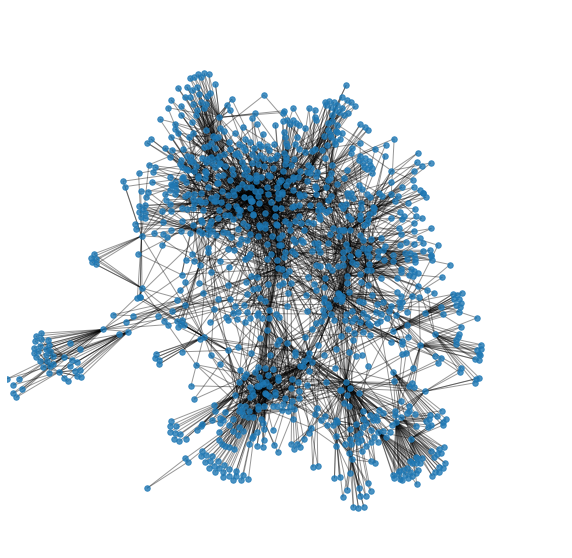

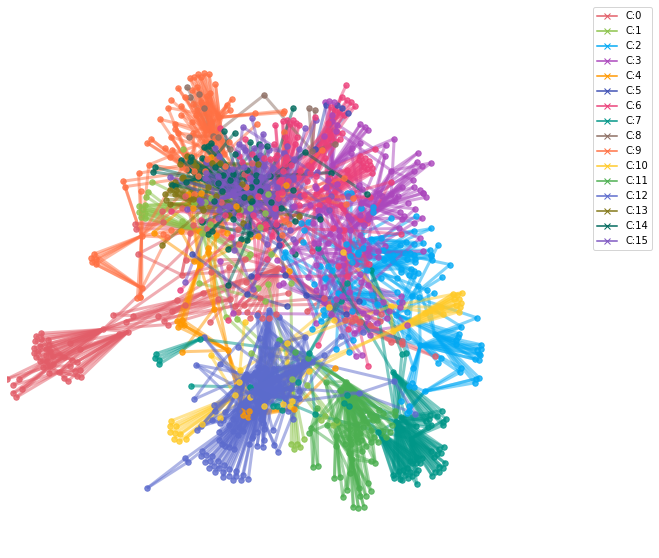

In [3]:
seed=0
# G,Id2Index,Index2Id,_=makeChengfGraph('resbak/1564383416897.json')
G,Id2Index,Index2Id,_=makeChengfGraph('mydata/15644561061175.json')
# G,Id2Index,Index2Id,_=makeChengfGraph('data/111111111111111111.json')
# G=makeCircleGraph()
# G=makeGraph3()
# G = nx.random_geometric_graph(1000, 0.125)
GA=graph2Matrix(G,norm=False)
L=LaplacianMatrix(GA)

####################老的方法##################################
# S,V=eig(L,maxK=30,maxTry=10,supportDim=300)
# print(S.shape)
# print(V.shape)
# K=proposalCluster(S,0.3)
# K=2
# print('classes:',K)

# labels=getCluster(K,V)
# labels=V[:,1]>0

####################新的方法#####################
labels=clusterHelper(L)

###############################################
plt.figure()
pos=drawGraph(G,cluster=None,node_size=30,seed=seed)
pos=drawGraph(G,labels,lineWidth=3,seed=seed,node_size=30)

### 话单数据

#全部节点数量,有临边节点数量,#边数量(双向): 1091 1091 4634


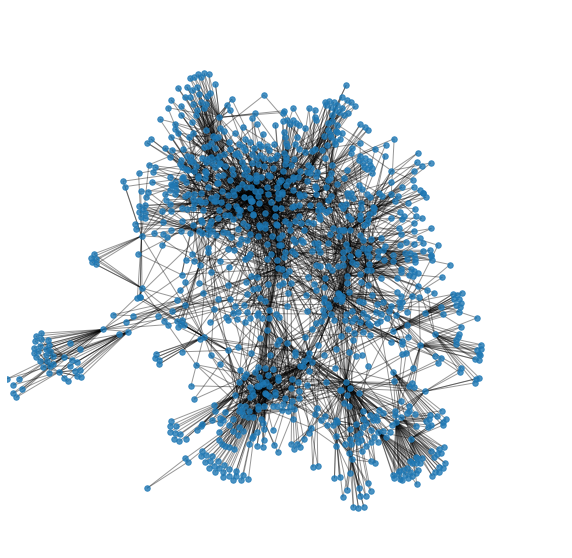

In [198]:
seed=0
filename='mydata/15644561061175.json'
# filename='test/src/15608547264745.json'
G,Id2Index,Index2Id,_=makeChengfGraph(filename)
pos=drawGraph(G,cluster=None,node_size=30,seed=seed)

In [199]:
L=LaplacianMatrix(graph2Matrix(G,norm=False))
S,V=eig(L)
######################老方法###################################

# K=proposalCluster(S,0.8)
# print('classes:',K)
# K=4
# labels=getCluster(K,V)
# labels=V[:,1]>0
#######################新方法##################################
labels=clusterHelper(L,complex=1.,minNode=30)
# pos=drawGraph(G,labels,lineWidth=1,node_size=30,seed=seed)

分割的节点数: 1091 复杂度: 2.9211732355637032
分割的节点数: 986 复杂度: 2.917849898580122
分割的节点数: 692 复杂度: 2.7109826589595376
分割的节点数: 648 复杂度: 2.753086419753086
分割的节点数: 535 复杂度: 2.736448598130841
分割的节点数: 410 复杂度: 2.8
分割的节点数: 379 复杂度: 2.7229551451187337
分割的节点数: 361 复杂度: 2.6094182825484764
分割的节点数: 294 复杂度: 2.8095238095238093
分割的节点数: 247 复杂度: 2.3360323886639676
分割的节点数: 234 复杂度: 2.341880341880342
分割的节点数: 222 复杂度: 2.9774774774774775
分割的节点数: 182 复杂度: 3.043956043956044
分割的节点数: 150 复杂度: 2.2933333333333334
分割的节点数: 125 复杂度: 1.632


### 根据分类提取出子图,然后可以对子图进行rank

聚类:0,节点数量:105,边数量(无向):228
聚类:1,节点数量:44,边数量(无向):55
聚类:2,节点数量:113,边数量(无向):196
聚类:3,节点数量:31,边数量(无向):49
聚类:4,节点数量:18,边数量(无向):25
聚类:5,节点数量:114,边数量(无向):227
聚类:6,节点数量:72,边数量(无向):148
聚类:7,节点数量:13,边数量(无向):17
聚类:8,节点数量:84,边数量(无向):175
聚类:9,节点数量:40,边数量(无向):68
聚类:10,节点数量:65,边数量(无向):173
聚类:11,节点数量:117,边数量(无向):394
聚类:12,节点数量:122,边数量(无向):276
聚类:13,节点数量:28,边数量(无向):48
聚类:14,节点数量:68,边数量(无向):120
聚类:15,节点数量:57,边数量(无向):92


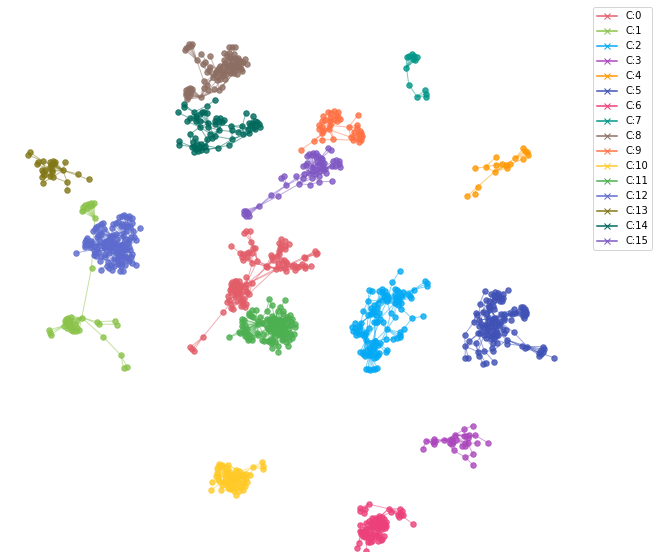

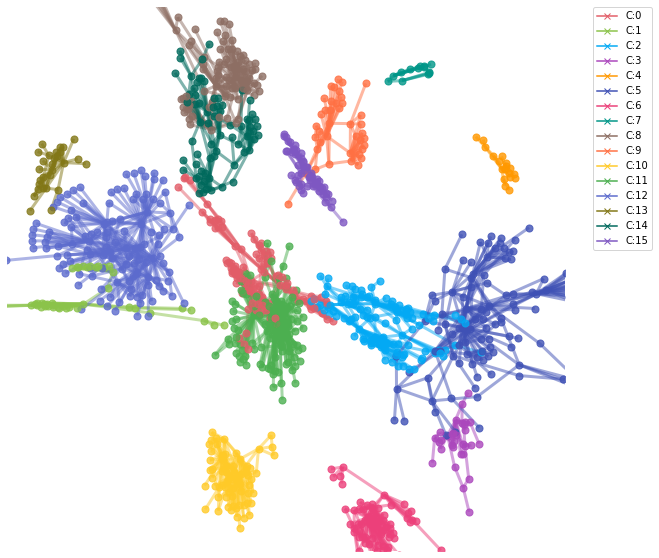

In [200]:
subgraphs=get_subGraph(G,labels)
H=nx.Graph()
for k,sub in subgraphs.items():
    H.add_edges_from(sub['graph'].edges())
pos=drawGraph(H,labels,lineWidth=1,node_size=30,seed=seed,scale=1)

pos_new=scalePosition(pos,labels,factor=3.0)
pos_new={i:pos_new[i] for i in range(len(pos_new))}
_=drawGraph(H,cluster=labels,node_size=50,pos=pos_new)

In [196]:
Index2Id={x:x for x in G.nodes}

In [62]:
cluster_rank=SubGraphPageRank(subgraphs,
                              global_name_fn=Index2Id,
                              topK=-1,alpha=0.85,maxiters=300,eps=0.01)
# cluster_rank

使用稀疏表示法


In [63]:
##显示子图,然后观测子图的rank

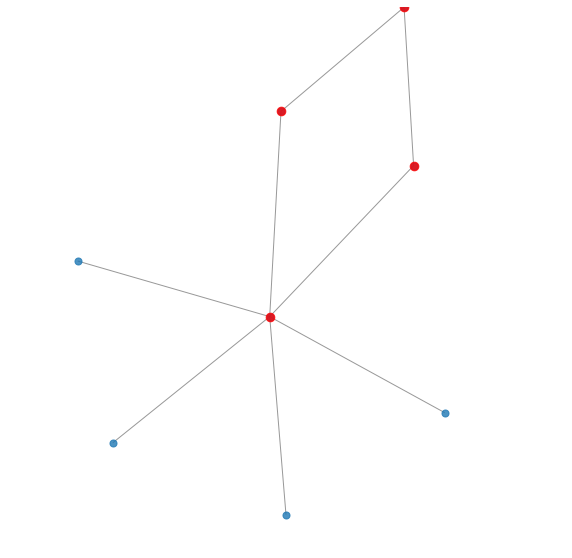

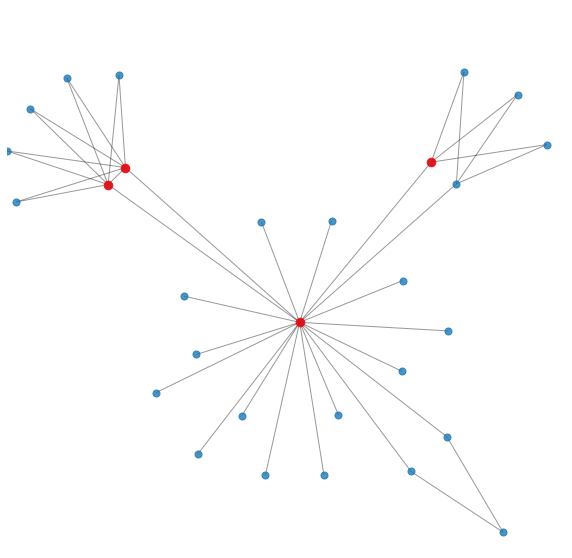

In [64]:
for clusterId in range(len(cluster_rank)):
    g=subgraphs[clusterId]['graph']
    highlight_node=cluster_rank[clusterId]['top_index'][:4]
    g_pos=drawGraph(g,node_size=50,seed=seed,highlight_node=highlight_node)

In [183]:
def scalePosition(pos,label,factor=1.0):
    def aa(P):
        center=P.mean(axis=0,keepdims=True)
        P_center=P-center
        M=P_center.T.dot(P_center)
        U,S,V=np.linalg.svd(M,False)
        u1,u2=U[:,0],U[:,1]
        Q=np.array([u1,u2])
        
#         diag=factor*np.diag([S[0],S[1]])
        diag=np.eye(2)
        diag[0,0]=S[1]/S[0]
        
        r=P_center.dot(Q).dot(factor*diag).dot(Q.T)
        r=r+center
        return r

    pos = np.array([pos[i] for i in range(len(pos))])
    pos=pos.copy()
    clusters=np.unique(label)
    for k in clusters:
        mask=(label==k)
        cls_k=pos[mask]
    
        pos[mask]=aa(cls_k)
    return pos

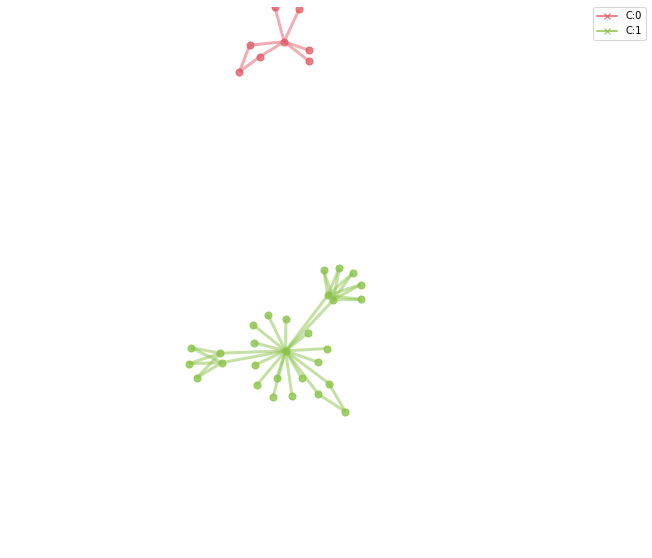

In [184]:
pos=drawGraph(H,cluster=labels,node_size=50,seed=0)

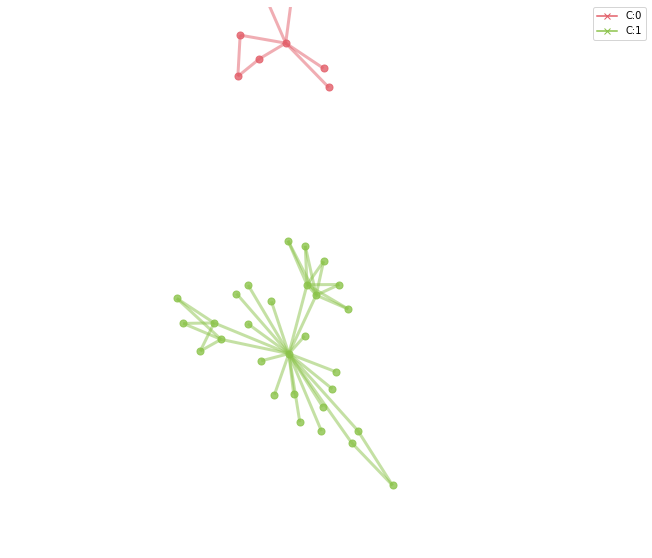

In [190]:
pos_new=scalePosition(pos,labels,factor=2.0)
pos_new={i:pos_new[i] for i in range(len(pos_new))}
_=drawGraph(H,cluster=labels,node_size=50,pos=pos_new)

In [78]:
k=0
mask=(labels==k)
pos = np.array([pos[i] for i in range(len(pos))])
pa=pos[mask]

8


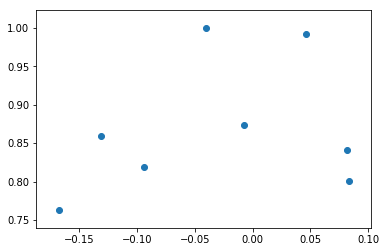

In [79]:
plt.scatter(pa[:,0],pa[:,1])
print(len(pa))

In [80]:
center=pa.mean(axis=0,keepdims=True)
pa_center=pa-center

In [94]:
M=pa_center.T.dot(pa_center)
U,S,V=np.linalg.svd(pa_center,False)

In [95]:
u1,u2=U[:,0],U[:,1]
print(u1)

[ 0.22891568  0.07363465  0.47549087 -0.32789645 -0.63348271  0.27976394
 -0.29756286  0.20113688]


In [89]:
Q=np.array([u1,u2])
QT=Q.T


In [90]:
Q.dot(QT)

array([[1.00000000e+00, 2.77555756e-16],
       [2.77555756e-16, 1.00000000e+00]])

In [98]:
def aa(P,factor=1.0):
    center=P.mean(axis=0,keepdims=True)
    P_center=P-center
    M=P_center.T.dot(P_center)
    U,S,V=np.linalg.svd(pa_center,False)
    u1,u2=U[:,0],U[:,1]
    Q=np.array([u1,u2])
    
    diag=factor*np.diag([S[0],S[0]])
    r=P.dot(Q).dot(diag).dot(Q.T)
    r=r+center
    return r